<a href="https://colab.research.google.com/github/srikarreddy1729/DL4ES/blob/main/sandbox/working_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip install gdal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 26.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import os
import numpy as np
import rasterio
from osgeo import gdal, osr
import keras
import tensorflow as tf


In [4]:
datapath = '/content/gdrive/MyDrive/exp/'
ps = 'crop_mask.tif'
patch_size = 256
roipath = '/content/gdrive/MyDrive/exp/other images/roi_folder/'
roishape = 'area2_square.geojson'

In [5]:
from tensorflow.keras.utils import to_categorical
def onehotencoding(labels, num_classes=23):
  return to_categorical(labels, num_classes)

In [6]:
#target clipping

rasterfile = gdal.Open(datapath + ps)

print('\nPerforming the clip operation...\n')


warp_options = gdal.WarpOptions(cutlineDSName = roipath + roishape, cropToCutline = True)
rasterfile_new = ps.split('.tif')[0] + '_roi.tif'
print(roipath + rasterfile_new, datapath + ps )
ds = gdal.Warp(roipath + rasterfile_new, datapath + ps,  options = warp_options)

cols = ds.RasterXSize
rows = ds.RasterYSize
bands = ds.RasterCount
projInfo = ds.GetProjection()
spatialRef = osr.SpatialReference()
spatialRef.ImportFromWkt(projInfo)
spatialRefProj = spatialRef.ExportToProj4()
ds = None

print('\nClipped raster input: ', rasterfile_new)
print('Checking spatial reference info\n')
print ("WKT format: " + str(spatialRef))
print ("Proj4 format: " + str(spatialRefProj))
print ("Number of columns: " + str(cols))
print ("Number of rows: " + str(rows))
print ("Number of bands: " + str(bands))


Performing the clip operation...

/content/gdrive/MyDrive/exp/other images/roi_folder/crop_mask_roi.tif /content/gdrive/MyDrive/exp/crop_mask.tif

Clipped raster input:  crop_mask_roi.tif
Checking spatial reference info

WKT format: PROJCS["WGS 84 / UTM zone 50S",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",10000000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","

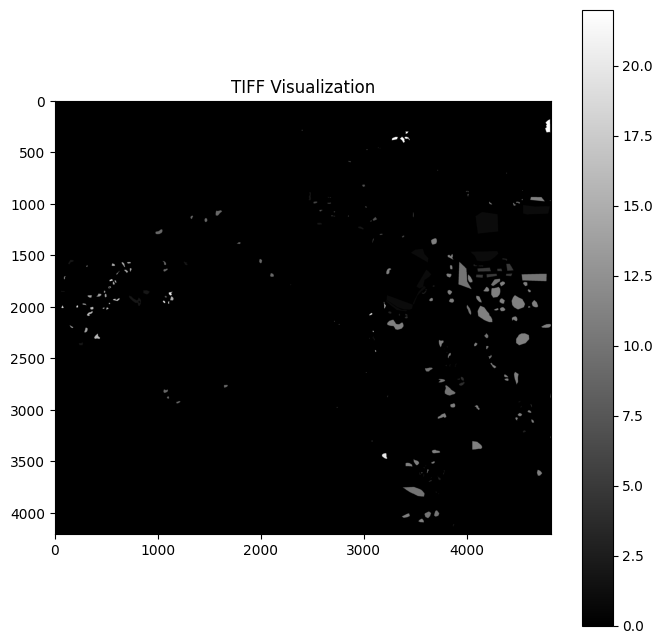

In [13]:
import matplotlib.pyplot as plt

tiff_path = '/content/gdrive/MyDrive/exp/other images/roi_folder/crop_mask_roi.tif'

with rasterio.open(tiff_path) as src:
    # Read the image data from the TIFF file
    img = src.read(1)

    # Display the image using Matplotlib
    plt.figure(figsize=(8, 8))  # Set the figure size
    plt.imshow(img, cmap='gray')  # You can change the colormap as needed
    plt.colorbar()  # Add a colorbar to the plot
    plt.title("TIFF Visualization")  # Set the title of the plot

    # Show the plot
    plt.show()

1. Create target pipeline

*   Get the target image and apply preprocessing and create patches
*   apply sampling function and return only useful masks and their indexes



In [14]:
def target_preprocessing(folder_path, patch_size):




    with rasterio.open(folder_path) as src:
        # Read the TIFF data
        output_mask = src.read()

        # Get the shape of the TIFF data
        num_bands, height, width = output_mask.shape

        # Calculate the new width and height that are multiples of the patch size
        new_width = int(np.floor(width / patch_size)) * patch_size
        new_height = int(np.floor(height / patch_size)) * patch_size

        print("cropped dimensions:", new_height, new_width)

        output_mask = np.moveaxis(output_mask, 0, -1)

        # Crop the input_image to the new dimensions
        cropped_mask = output_mask[:new_height, :new_width, :]

    new_mask = np.squeeze(cropped_mask)

    masks = []
    for i in range(0, new_mask.shape[0], patch_size):
        for j in range(0, new_mask.shape[1], patch_size):
            patch = new_mask[i:i+patch_size, j:j+patch_size]
            masks.append(patch)

    mask_array = np.array(masks)

    useful_masks = []
    useless = 0
    indexes = []
    for index,img in enumerate(mask_array):

        val, counts = np.unique(img, return_counts=True)

        if (1 - (counts[0]/counts.sum())) > 0.05:
          useful_masks.append(img)
          indexes.append(index)
        else:
          #print("I am useless")
          useless +=1


    print("Total useful images are: ", len(mask_array)-useless)
    print(indexes)
    print("Total useless images are: ", useless)

    useful_masks_array = np.array(useful_masks)

    useful_masks_onehot = to_categorical(useful_masks_array)






    return useful_masks, useful_masks_onehot, indexes






Test the target_preprocessing function: see if it is returning useful_masks
and indexes

In [15]:
folder_path = '/content/gdrive/MyDrive/exp/other images/roi_folder/crop_mask_roi.tif'
patch_size = 256
target = target_preprocessing(folder_path,patch_size)

cropped dimensions: 4096 4608
Total useful images are:  29
[88, 89, 103, 104, 106, 110, 121, 122, 123, 124, 125, 127, 129, 138, 139, 141, 142, 143, 156, 160, 161, 179, 194, 197, 212, 247, 265, 283, 284]
Total useless images are:  259


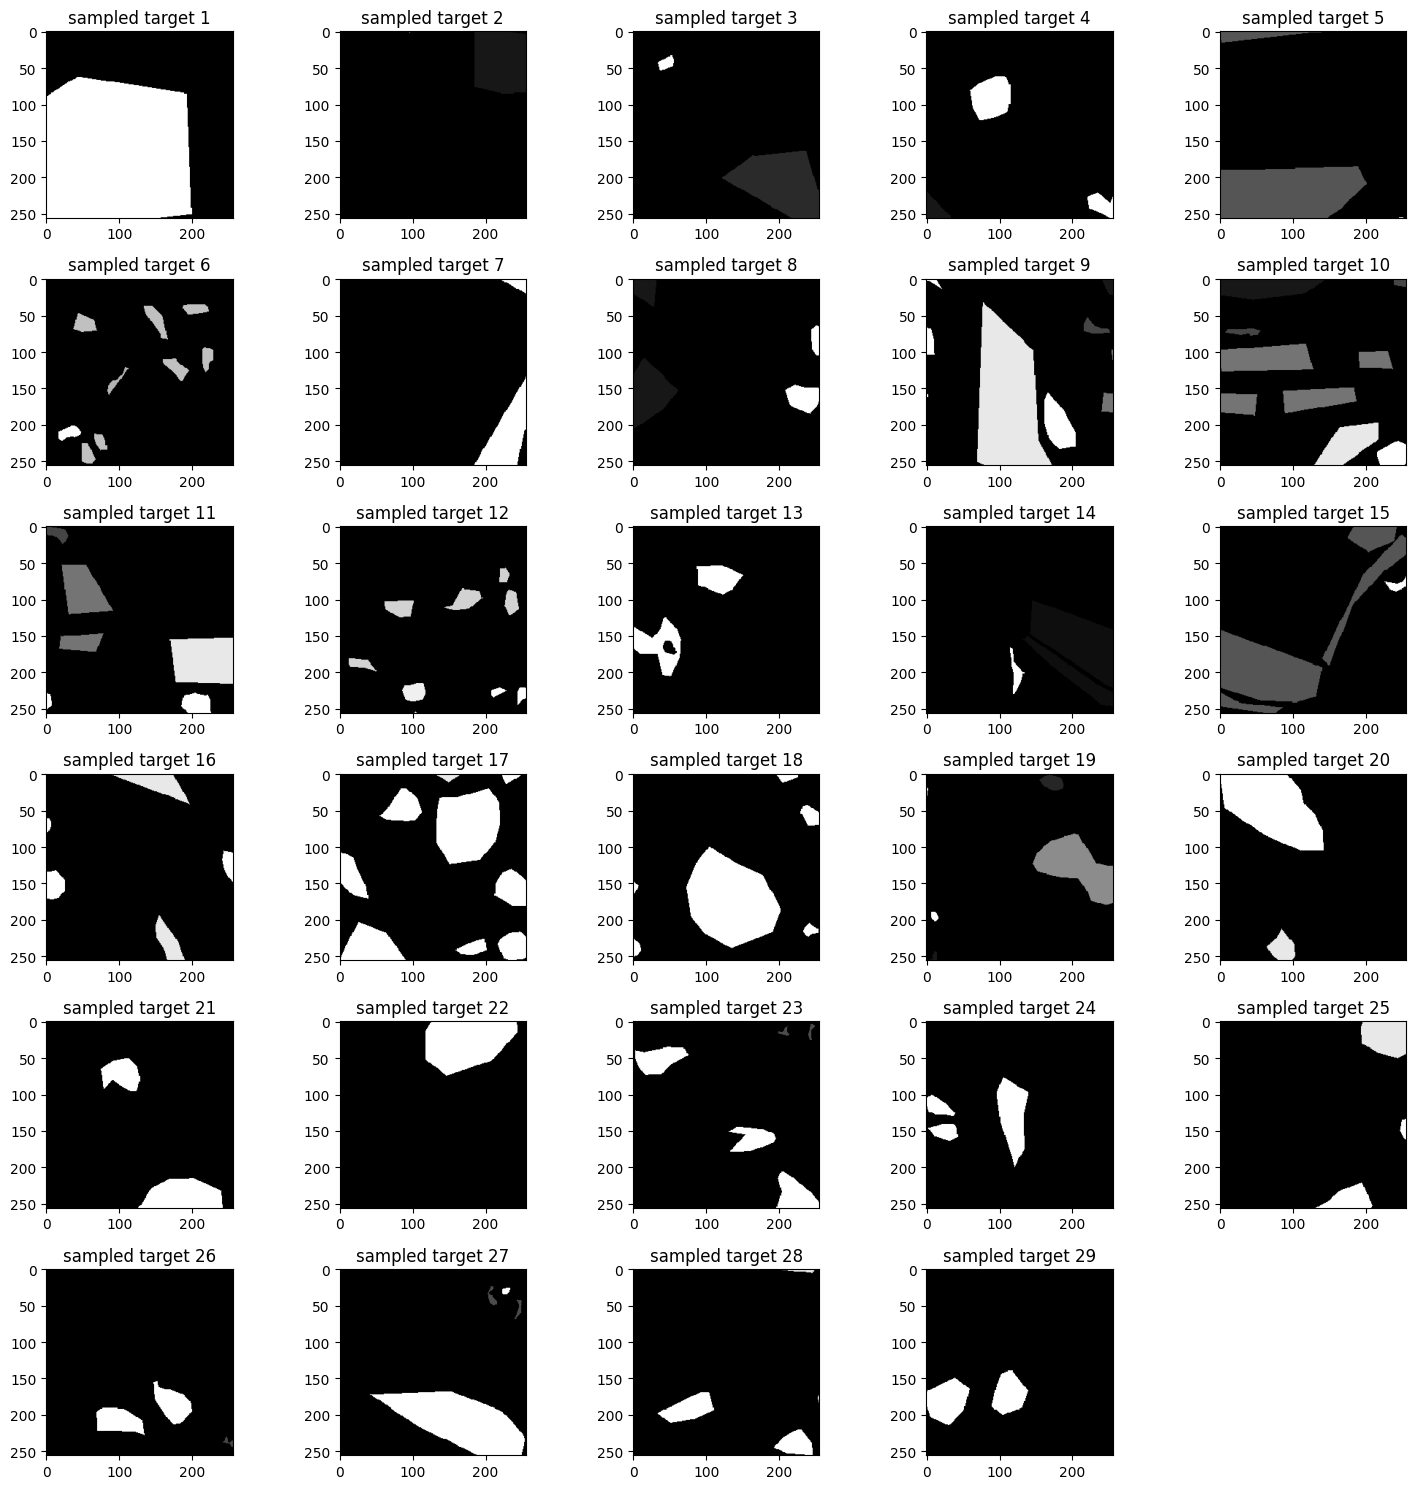

In [16]:

array_list = target[0]

# Define the grid layout
rows, cols = 6, 5  # Change these values to match your desired grid layout

# Create a Matplotlib figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Adjust the figure size as needed

# Iterate through the list of arrays and display them in subplots
for i in range(len(array_list)):
    row, col = i // cols, i % cols
    ax = axes[row, col]
    ax.imshow(array_list[i], cmap='gray')  # Change the colormap as needed
    ax.set_title(f"sampled target {i + 1}")

# Hide any empty subplots (if the number of arrays is less than rows*cols)
for i in range(len(array_list), rows * cols):
    row, col = i // cols, i % cols
    fig.delaxes(axes[row, col])

# Adjust spacing between subplots
fig.tight_layout()

# Show or save the figure
plt.show()  # To display the figure
# plt.savefig('image_grid.png')  # To save the figure as an image



In [ ]:
(target[0][0]).shape

(256, 256, 21)

In [17]:
unique_values = np.unique(np.concatenate(array_list))

In [18]:
print(unique_values)

[ 0.  1.  2.  3.  5.  6. 10. 11. 14. 15. 16. 17. 18. 20.]


In [20]:
print(target[1][0].shape)


(256, 256, 21)


1. Create a preprocessing loop for a folder containing images


*   Each image needs to be clipped, processed, sampled

*   the processed images should go into a list, and correspondingly a list should be filled up with target equivalent to the number of images


In [21]:

def newclipping(datapath,roipath,ps, roishape):
  rasterfile = gdal.Open(datapath + ps)

  print('\nPerforming the clip operation...\n')


  warp_options = gdal.WarpOptions(cutlineDSName = roipath + roishape, cropToCutline = True)
  rasterfile_new = ps.split('.tif')[0] + '_roi.tif'
  print(roipath + rasterfile_new, datapath + ps )
  ds = gdal.Warp(roipath + rasterfile_new, datapath + ps,  options = warp_options)

  cols = ds.RasterXSize
  rows = ds.RasterYSize
  bands = ds.RasterCount
  projInfo = ds.GetProjection()
  spatialRef = osr.SpatialReference()
  spatialRef.ImportFromWkt(projInfo)
  spatialRefProj = spatialRef.ExportToProj4()
  ds = None

  print('\nClipped raster input: ', rasterfile_new)
  print('Checking spatial reference info\n')
  print ("WKT format: " + str(spatialRef))
  print ("Proj4 format: " + str(spatialRefProj))
  print ("Number of columns: " + str(cols))
  print ("Number of rows: " + str(rows))
  print ("Number of bands: " + str(bands))

  return roipath + rasterfile_new



In [22]:
def preprocessing(filelocation,patch_size):
    # Load the GeoTIFF file
    with rasterio.open(filelocation) as src:
        # Read the TIFF data
        tiff_data = src.read()
        print("total number of nan in original",np.count_nonzero(np.isnan(tiff_data)))

        # Get the shape of the TIFF data
        num_bands, height, width = tiff_data.shape

        print("Original image dimensions:", num_bands, height, width)
        unique_elements, counts_elements = np.unique(tiff_data, return_counts=True)
        print(unique_elements, counts_elements )
        print("total unique",len(counts_elements))

        print(np.min(tiff_data), np.max(tiff_data))


        normalized_image = np.zeros_like(tiff_data, dtype='float32')

        for band, count in enumerate(range(tiff_data.shape[0])):
            band_data = tiff_data[band, :, :]
            band_min = np.min(band_data)
            band_max = np.max(band_data)
            print("band-", count+1,"maximum-",band_max,"minimum-",band_min)
            #print(band_data)
            #epsilon is added to prevent division by zero
            normalized_band = (band_data - band_min) / (band_max - band_min + 1e-10)
            normalized_image[band, :, :] = normalized_band

        # Calculate the new width and height that are multiples of the patch size
        new_width = int(np.floor(width / patch_size)) * patch_size
        new_height = int(np.floor(height / patch_size)) * patch_size

        print("cropped dimensions:", new_height, new_width)

        input_image = np.moveaxis(normalized_image, 0, -1)

        # Crop the input_image to the new dimensions
        cropped_array = input_image[:new_height, :new_width, :]

    print("total number of nan",np.count_nonzero(np.isnan(cropped_array)))
    print("Cropped array shape:", cropped_array.shape)
    print(np.min(cropped_array), np.max(cropped_array))

    patches = []
    for i in range(0, cropped_array.shape[0], patch_size):
        for j in range(0, cropped_array.shape[1], patch_size):
            patch = cropped_array[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    print("patches are created")
    return patches

In [29]:
def sampling(patches,indexes):
    useful_patches = []
    for number_of_masks,i in enumerate(indexes):
      print(i)
      if i < len(patches):
        useful_patches.append(patches[i])
      else:
        break
    return useful_patches, number_of_masks



In [28]:
def process_images_in_folder(datapath, patch_size, roipath,target, roishape = 'area2_square.geojson'):
    # Initialize an empty list to store the sampled patches and target_patches
    sampled_image_patches = []
    target_patches = []

    # Loop through all files in the folder
    for ps in os.listdir(datapath):

        # #print(type(filename),filename.split('.tif')[0] + '_roi.tif' )
        # print(folder_path + ps)
        # print(roipath + roishape)
        # print(ps)

        # Apply clipping
        clipped_image_path = newclipping(datapath,roipath,ps, roishape)

        # Preprocess(normalize,resize,create patches) the clipped image
        patches = preprocessing(clipped_image_path, patch_size)
        print(len(patches))

        # Sample patches from the processed image patches and create corresponding target patches
        #print(target[2])
        #print(len(target[2]))
        useful_patches, number_of_masks = sampling(patches,target[2])
        sampled_image_patches.extend(useful_patches)
        target_patches.extend(target[1][0:number_of_masks])
        print(len(sampled_image_patches),len(target_patches) )


    return sampled_image_patches,target_patches

Test the function for two images:


1.   create a folder containing two images
2.   check how many image patches and target patches are formed
3. visualise them





In [32]:
datapath = '/content/gdrive/MyDrive/exp/other images/test_folder/'
roipath = '/content/gdrive/MyDrive/exp/other images/roi_folder/'
patch_size = 256

dataset = process_images_in_folder(datapath, patch_size, roipath, target)


Performing the clip operation...

/content/gdrive/MyDrive/exp/other images/roi_folder/area2_0803_2022_8bands_roi.tif /content/gdrive/MyDrive/exp/other images/test_folder/area2_0803_2022_8bands.tif

Clipped raster input:  area2_0803_2022_8bands_roi.tif
Checking spatial reference info

WKT format: PROJCS["WGS 84 / UTM zone 50S",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",10000000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Ea

1. fix the one-hot encoding
2. modularize the process and put everything in one file
3. build the training loop from the output of 2.


In [39]:
len(dataset[0])
dataset[0][0].shape

(256, 256, 8)

In [ ]:
dataset[0]

In [43]:
num_val_samples = 20

train_input_imgs = dataset[0][:-num_val_samples]
train_targets = dataset[1][:-num_val_samples]

val_input_imgs = dataset[0][-num_val_samples:]
val_targets = dataset[1][-num_val_samples:]

In [48]:
len(train_targets)

58

In [49]:
len(train_input_imgs)

58

In [40]:
dataset[1][0].shape

(256, 256, 21)

In [56]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (8,))
    x = inputs

    # Encoder
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    conv1 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat4 = layers.Concatenate()([up4, conv2])
    conv4 = layers.Conv2D(32, 3, activation="relu", padding="same")(concat4)
    conv4 = layers.Conv2D(32, 3, activation="relu", padding="same")(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv1])
    conv5 = layers.Conv2D(16, 3, activation="relu", padding="same")(concat5)
    conv5 = layers.Conv2D(16, 3, activation="relu", padding="same")(conv5)

    # Output
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(conv5)

    model = keras.Model(inputs, outputs)
    return model

img_size = (256, 256)
num_classes = 21
model = get_model(img_size=img_size, num_classes=num_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 8)]        0         []                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 256, 256, 16)         1168      ['input_4[0][0]']             
                                                                                                  
 conv2d_30 (Conv2D)          (None, 256, 256, 16)         2320      ['conv2d_29[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)         0         ['conv2d_30[0][0]']           
 g2D)                                                                                       

In [67]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("new_segmentation.hdf5",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=5,
                    callbacks=callbacks,
                    batch_size=8,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/5
8/8 [==============================] - 37s 4s/step - loss: 2.4048 - val_loss: 1.9760
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 35s 4s/step - loss: 1.9625 - val_loss: 1.7757
Epoch 3/5
8/8 [==============================] - 33s 4s/step - loss: 1.8380 - val_loss: 1.6817
Epoch 4/5
8/8 [==============================] - 33s 4s/step - loss: 1.7694 - val_loss: 1.8742
Epoch 5/5
8/8 [==============================] - 33s 4s/step - loss: 1.7024 - val_loss: 1.4821


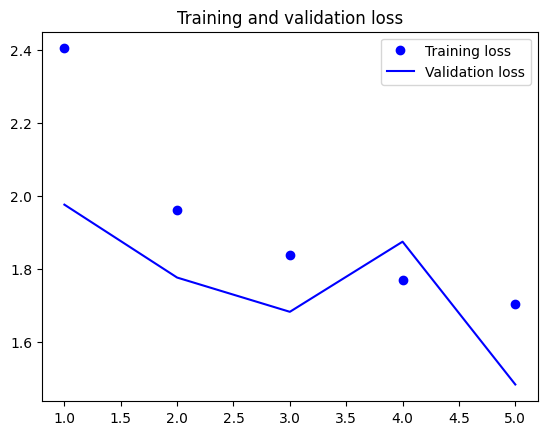

In [69]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [60]:
import numpy as np
import random

img_size = (256, 256)
num_imgs = len(dataset[0])

input_img_paths = dataset[0]
target_paths = dataset[1]

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)


input_imgs = np.zeros((num_imgs,) + img_size + (8,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (21,), dtype="uint8")

for i in range(num_imgs):

    input_imgs[i] = input_img_paths[i]
    targets[i] = target_paths[i]

num_val_samples = round(0.2 * num_imgs)

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]



In [68]:
round(0.2 * num_imgs)

16

In [61]:
train_input_imgs.shape

(58, 256, 256, 8)

In [62]:
train_targets.shape

(58, 256, 256, 21)

In [63]:
val_input_imgs.shape

(20, 256, 256, 8)

In [64]:
val_targets.shape

(20, 256, 256, 21)

1. Target preprocessing

2. Data preprocessing

3. model loading and training


In [ ]:
#target clipping

rasterfile = gdal.Open(datapath + ps)

print('\nPerforming the clip operation...\n')


warp_options = gdal.WarpOptions(cutlineDSName = roipath + roishape, cropToCutline = True)
rasterfile_new = ps.split('.tif')[0] + '_roi.tif'
print(roipath + rasterfile_new, datapath + ps )
ds = gdal.Warp(roipath + rasterfile_new, datapath + ps,  options = warp_options)

cols = ds.RasterXSize
rows = ds.RasterYSize
bands = ds.RasterCount
projInfo = ds.GetProjection()
spatialRef = osr.SpatialReference()
spatialRef.ImportFromWkt(projInfo)
spatialRefProj = spatialRef.ExportToProj4()
ds = None

print('\nClipped raster input: ', rasterfile_new)
print('Checking spatial reference info\n')
print ("WKT format: " + str(spatialRef))
print ("Proj4 format: " + str(spatialRefProj))
print ("Number of columns: " + str(cols))
print ("Number of rows: " + str(rows))
print ("Number of bands: " + str(bands))


from tensorflow.keras.utils import to_categorical
def onehotencoding(labels, num_classes=23):
  return to_categorical(labels, num_classes)


datapath = '/content/gdrive/MyDrive/exp/'
ps = 'crop_mask.tif'
patch_size = 256
roipath = '/content/gdrive/MyDrive/exp/other images/roi_folder/'
roishape = 'area2_square.geojson'

#target preprocessing

def target_preprocessing(folder_path, patch_size):

    with rasterio.open(folder_path) as src:
        # Read the TIFF data
        output_mask = src.read()

        # Get the shape of the TIFF data
        num_bands, height, width = output_mask.shape

        # Calculate the new width and height that are multiples of the patch size
        new_width = int(np.floor(width / patch_size)) * patch_size
        new_height = int(np.floor(height / patch_size)) * patch_size

        print("cropped dimensions:", new_height, new_width)

        output_mask = np.moveaxis(output_mask, 0, -1)

        # Crop the input_image to the new dimensions
        cropped_mask = output_mask[:new_height, :new_width, :]

    new_mask = np.squeeze(cropped_mask)

    masks = []
    for i in range(0, new_mask.shape[0], patch_size):
        for j in range(0, new_mask.shape[1], patch_size):
            patch = new_mask[i:i+patch_size, j:j+patch_size]
            masks.append(patch)

    mask_array = np.array(masks)

    useful_masks = []
    useless = 0
    indexes = []
    for index,img in enumerate(mask_array):

        val, counts = np.unique(img, return_counts=True)

        if (1 - (counts[0]/counts.sum())) > 0.05:
          useful_masks.append(img)
          indexes.append(index)
        else:
          #print("I am useless")
          useless +=1


    print("Total useful images are: ", len(mask_array)-useless)
    print(indexes)
    print("Total useless images are: ", useless)

    useful_masks_array = np.array(useful_masks)

    useful_masks_onehot = to_categorical(useful_masks_array)






    return useful_masks, useful_masks_onehot, indexes


